## Acknowledgements

This project draws inspiration from Swandip Singha’s excellent Kaggle notebook:
[S5E5 | EDA | FE | XGBoost](https://www.kaggle.com/code/swandipsingha/s5e5-eda-fe-xgboost)

While some of the EDA ideas and visualization styles are adapted from his work,  
all feature engineering, model training, and parameter tuning were independently implemented by myself as part of my learning journey.

## 鳴謝

本專案的初步探索分析（EDA）部份受到 Swandip Singha 在 Kaggle 上精彩分享的啟發：
[S5E5 | EDA | FE | XGBoost](https://www.kaggle.com/code/swandipsingha/s5e5-eda-fe-xgboost)

我參考了部分探索性分析與視覺化呈現方式，  
但所有的特徵工程、模型訓練、參數調整，皆為我在學習過程中獨立實作與完成。

## EDA 探索式資料分析

本專案使用的資料來自 Kaggle 所舉辦的比賽：

[Playground Series - Season 5, Episode 5 (S5E5)](https://www.kaggle.com/competitions/playground-series-s5e5)

本競賽目標為預測每個樣本的熱量消耗量（Calories），資料集包含個體的性別、年齡、身高、體重、體溫、心率及運動時間等資訊，屬於一個迴歸問題（Regression Task）。

檔案簡介：  
	•	train.csv：包含訓練用的特徵與目標欄位 Calories  
	•	test.csv：包含測試用的特徵欄位（需預測 Calories）  
	•	sample_submission.csv：提交格式參考  

### 導入必要套件與讀取資料集

以下導入本專案進行資料探索分析所需的基礎套件，包括：  

- `numpy` / `pandas`：用於資料處理與統計計算  
- `matplotlib.pyplot` / `seaborn`：繪製分布圖與變數間關係圖  
- `warnings`：關閉警告訊息，保持輸出整潔  

接著讀取本地資料夾中預先下載好的比賽資料集：  

- `train.csv`：訓練資料，包含輸入特徵與目標變數 `Calories`  
- `test.csv`：測試資料，不含目標變數，供預測使用  

由於此 Notebook 放在 `notebooks/` 子資料夾下，因此使用相對路徑 `../data/...` 回到上層資料夾載入檔案。

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

### 資料欄位簡介

根據官方比賽說明，訓練資料包含以下欄位：

| 欄位名稱     | 說明                             |
|--------------|----------------------------------|
| `ID`         | 樣本編號                          |
| `Gender`     | 性別（Male / Female）            |
| `Age`        | 年齡（單位：歲）                  |
| `Height`     | 身高（公分）                      |
| `Weight`     | 體重（公斤）                      |
| `Duration`   | 運動時間（分鐘）                  |
| `Heart_Rate` | 當下運動時的心率（bpm）           |
| `Body_Temp`  | 體溫（攝氏）                      |
| `Calories`   | 預測目標：運動所消耗的卡路里（kcal） |

In [9]:
train_df = pd.read_csv("../data/train.csv")
test_df = pd.read_csv("../data/test.csv")

### 資料欄位資訊（Data Overview）

以下列出訓練資料的欄位名稱、資料型態與非空值數量，可幫助了解是否有缺值，並確認欄位格式是否正確。

In [30]:
# 檢查訓練集大小 (75萬個rows, 9個columns)
print(f"Dataset Shape: {train_df.shape}") 

# 查看info
print("\nData Info:")
train_df.info() 

# 用describe查看資料數據分佈
print("\nNumerical Features Summary:") 
display(train_df.describe())

# 用head查看前十筆資料
print("\nFirst 10 Rows of the Dataset:")
display(train_df.head(10))

Dataset Shape: (750000, 9)

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          750000 non-null  int64  
 1   Sex         750000 non-null  object 
 2   Age         750000 non-null  int64  
 3   Height      750000 non-null  float64
 4   Weight      750000 non-null  float64
 5   Duration    750000 non-null  float64
 6   Heart_Rate  750000 non-null  float64
 7   Body_Temp   750000 non-null  float64
 8   Calories    750000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 51.5+ MB

Numerical Features Summary:


,id,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,374999.500000,41.420404,174.697685,75.145668,15.421015,95.483995,40.036253,88.282781
std,216506.495284,15.175049,12.824496,13.982704,8.354095,9.449845,0.779875,62.395349
min,0.000000,20.000000,126.000000,36.000000,1.000000,67.000000,37.100000,1.000000
25%,187499.750000,28.000000,164.000000,63.000000,8.000000,88.000000,39.600000,34.000000
50%,374999.500000,40.000000,174.000000,74.000000,15.000000,95.000000,40.300000,77.000000
75%,562499.250000,52.000000,185.000000,87.000000,23.000000,103.000000,40.700000,136.000000
max,749999.000000,79.000000,222.000000,132.000000,30.000000,128.000000,41.500000,314.000000



First 10 Rows of the Dataset:


,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,4,female,38,166.0,61.0,25.0,102.0,40.6,146.0
5,5,female,26,156.0,56.0,19.0,100.0,40.5,103.0
6,6,female,21,172.0,73.0,3.0,81.0,38.3,9.0
7,7,male,46,188.0,94.0,23.0,100.0,40.8,145.0
8,8,female,33,166.0,63.0,25.0,107.0,40.5,161.0
9,9,male,65,185.0,88.0,23.0,104.0,41.0,185.0


**資料欄位資訊小結（Summary of Data Overview）**

根據初步資料結構檢視（`info()`、`describe()`、`head()`）的結果：

- 本次訓練資料集共 **750,000 筆樣本、9 個欄位**
- 所有欄位皆**無缺值**，**不需進行**缺值補處理
- 各欄位型態如下：
  - `id`, `Age`: 為整數類型，代表樣本編號與年齡  （`id`為無意義欄位，後續可以直接移除）
  - `Sex`: 為物件（字串）類別，需進一步轉為類別變數
  - `Height`, `Weight`, `Duration`, `Heart_Rate`, `Body_Temp`, `Calories`: 為連續數值型欄位（float），後續可進行分布分析與偏態處理
- `Calories` 為本次預測目標欄位（regression task）

整體資料結構乾淨、欄位命名清楚，適合直接進行特徵分析與建模。

### 數值特徵視覺化（Numerical Feature Visualization）

本段針對數值型欄位（如年齡、身高、體重、運動時間、心率、體溫與熱量）進行基本統計圖像分析，  
幫助我們理解以下幾個面向：

- 每個特徵的 **分布型態**（是否偏態、常態分布、集中於哪個範圍）
- 是否存在 **明顯離群值**
- 是否需要進行 **轉換處理**（如 log1p 或 Yeo-Johnson）

每張圖會同時顯示：
- 左圖：直方圖（Histogram）＋ KDE 曲線（密度）
- 右圖：箱型圖（Boxplot）用於檢查異常值

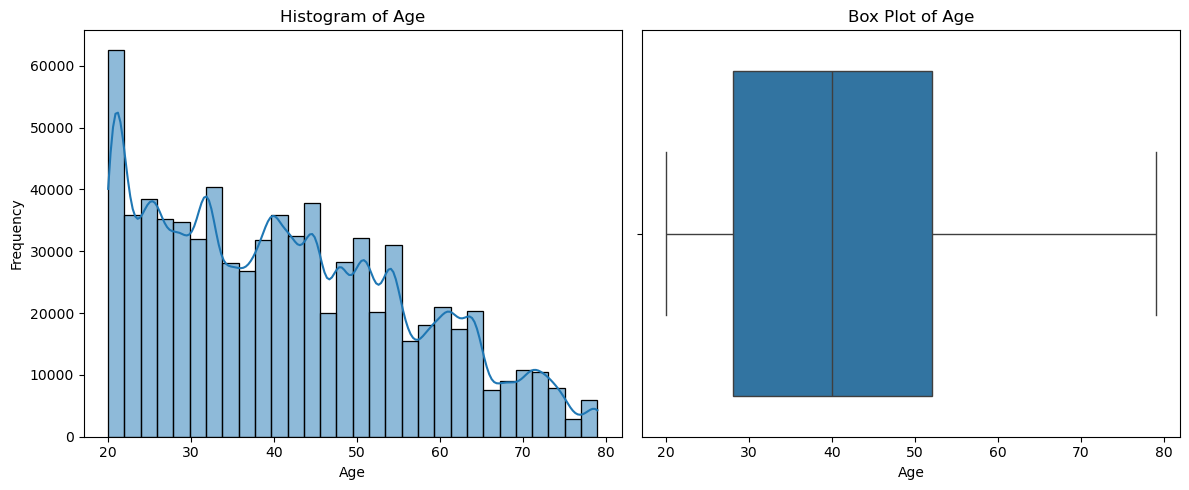


Statistics for Age:
Skewness: 0.44


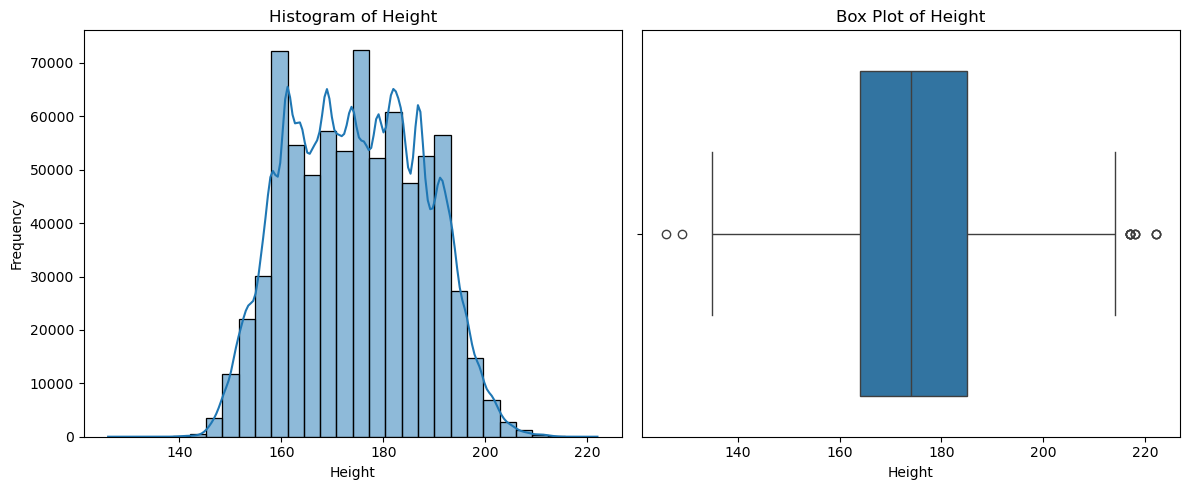


Statistics for Height:
Skewness: 0.05


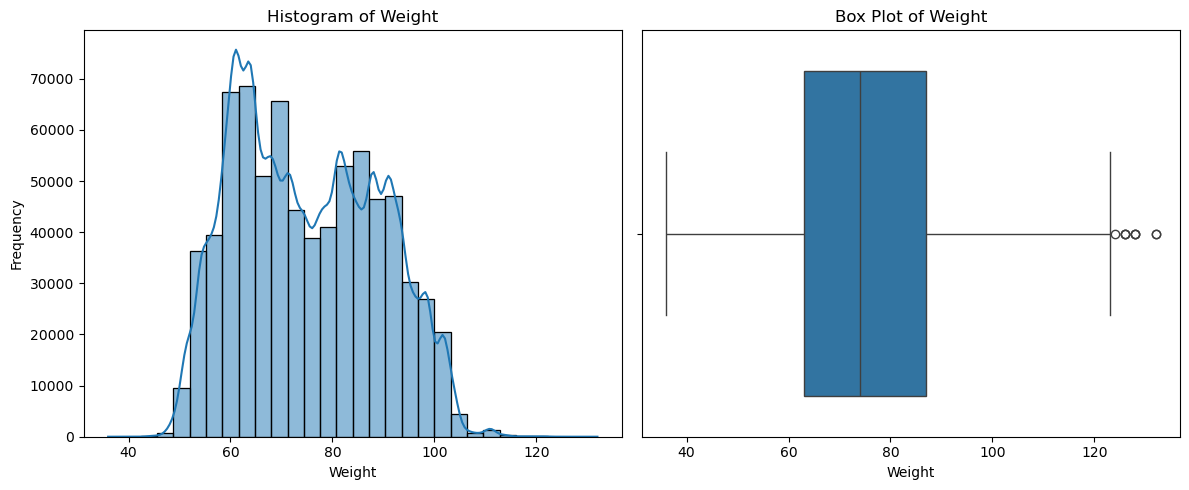


Statistics for Weight:
Skewness: 0.21


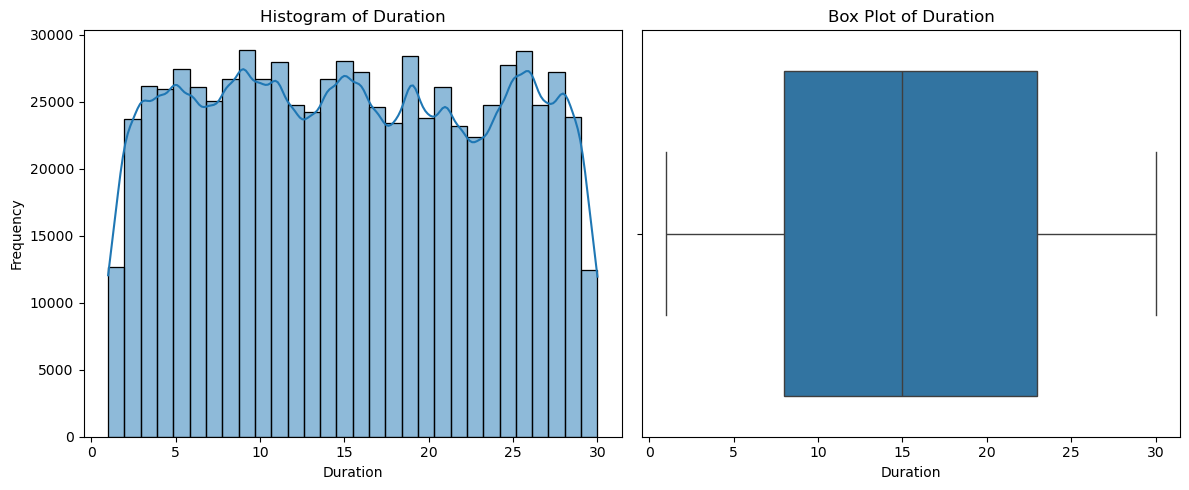


Statistics for Duration:
Skewness: 0.03


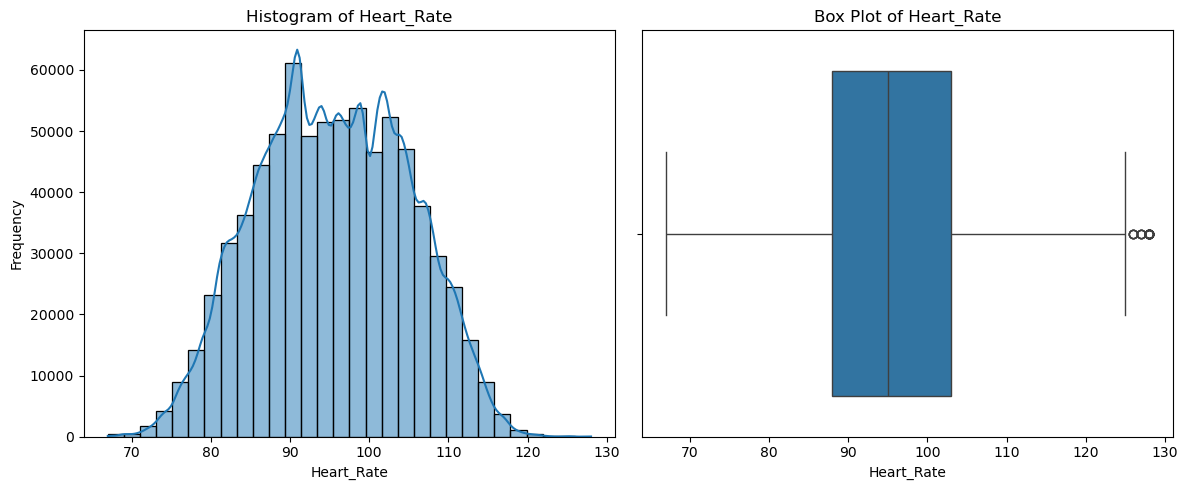


Statistics for Heart_Rate:
Skewness: -0.01


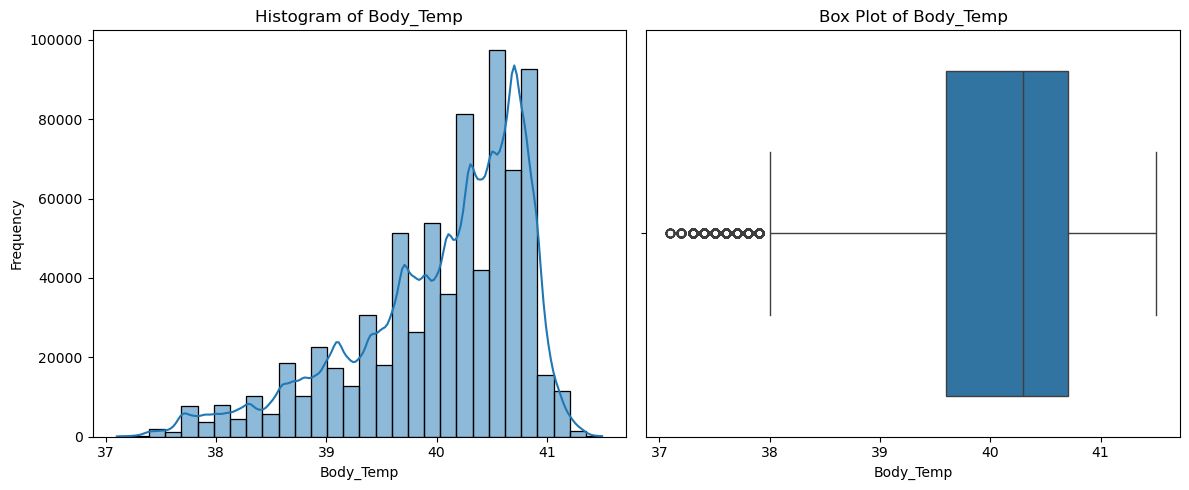


Statistics for Body_Temp:
Skewness: -1.02


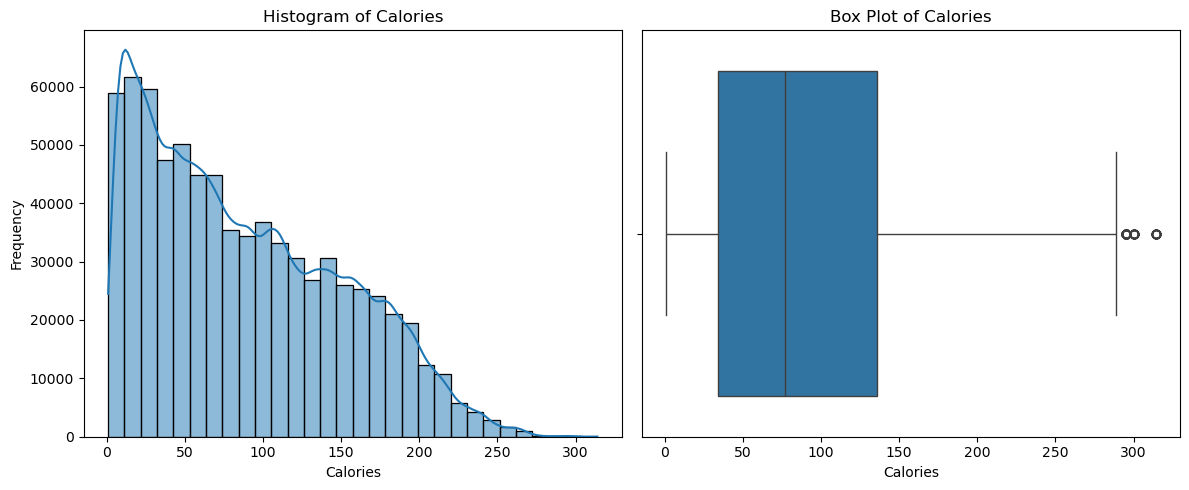


Statistics for Calories:
Skewness: 0.54


In [55]:
# Step 1：定義數值特徵欄位（除了 sex 與 id（無意義），其餘皆為數值特徵）
numerical_features = [
    "Age",         # 年齡
    "Height",      # 身高（cm）
    "Weight",      # 體重（kg）
    "Duration",    # 運動時長（分鐘）
    "Heart_Rate",  # 運動過程的心率（bpm）
    "Body_Temp",   # 體溫（攝氏）
    "Calories"     # 消耗熱量（預測目標）
]

# Step 2：對每個數值欄位做視覺化與統計分析
for feature in numerical_features:
    plt.figure(figsize=(12, 5))  # 設定畫布大小

    # 左圖：直方圖 + KDE 曲線（看分布形狀）
    plt.subplot(1, 2, 1)
    sns.histplot(train_df[feature], kde=True, bins=30)
    plt.title(f"Histogram of {feature}")      # 標題
    plt.xlabel(feature)                       # X 軸標籤
    plt.ylabel("Frequency")                   # Y 軸標籤

    # 右圖：箱型圖（可用來觀察是否有異常值）
    plt.subplot(1, 2, 2)
    sns.boxplot(x=train_df[feature])
    plt.title(f"Box Plot of {feature}")

    plt.tight_layout()  # 避免圖重疊
    plt.show()          # 顯示圖表

    # 顯示統計資訊
    print(f"\nStatistics for {feature}:")
    print(f"Skewness: {train_df[feature].skew():.2f}")   # 檢查是否偏態
    #(:啟動格式控制, .2保留 小數點後 2 位, f使用 浮點數格式（float）)

**數值特徵觀察小結（Summary of Numerical Features）**

下表總結了所有數值特徵的偏態情形、離群值狀況，以及考慮的前處理方法。  

| 特徵名稱     | Skewness  | 分布型態            | 離群值     | 處理方式                   |
|--------------|----------|------------------|-------------|--------------------------------|
| Age          | 0.44     | 近似常態 + 輕微右偏| 少量         | 可保留                         |
| Height       | 0.05     | 左右對稱          | 幾乎無       | 可保留                         |
| Weight       | 0.21     | 主體對稱 + 右尾偏態| 右側少量      | 視情況 log1p；也可直接使用     |
| Duration     | 0.03     | 左右對稱          | 幾乎無       | 可保留                      |
| Heart_Rate   | -0.01    | 左右對稱          | 右側少量      | 可保留或進行特徵分箱處理       |
| Body_Temp    | -1.02    | 明顯左偏（長尾在左）| 左側離群值大量存在| 進行特徵分箱處理           |
| Calories     | 0.54     | 中度右偏（長尾在右）| 右側少量      | 建議使用 log1p 或 Yeo-Johnson |

### 數值特徵分布圖：KDE（核密度估計）

為了更直觀地觀察每個數值特徵的分布情況，我們使用 **KDE 曲線圖（Kernel Density Estimation）** 對所有數值欄位進行視覺化。

KDE 可視為直方圖的平滑版本，幫助我們辨識：

- 資料是否呈現偏態（例如：右偏、左偏、近似常態）
- 分布是否為單峰（unimodal）或多峰（multimodal）
- 是否有極端值或異常尾端（如長尾）

| 特徵名稱     | 分布觀察小結                           |
|--------------|----------------------------------------|
| Age          | 輕度右偏，年齡集中於 20–50 區間        |
| Height       | 接近對稱分布，高峰落在 165–180 公分     |
| Weight       | 主體對稱，但右尾略長，有少數重度樣本   |
| Duration     | 呈現類似均勻分布（0–30 分鐘內）         |
| Heart_Rate   | 鐘型對稱分布，高峰約在 90–100 bpm      |
| Body_Temp    | 明顯左偏，高峰集中在 40–41°C           |
| Calories     | 明顯右偏，消耗熱量大多集中於 0–100 kcal |


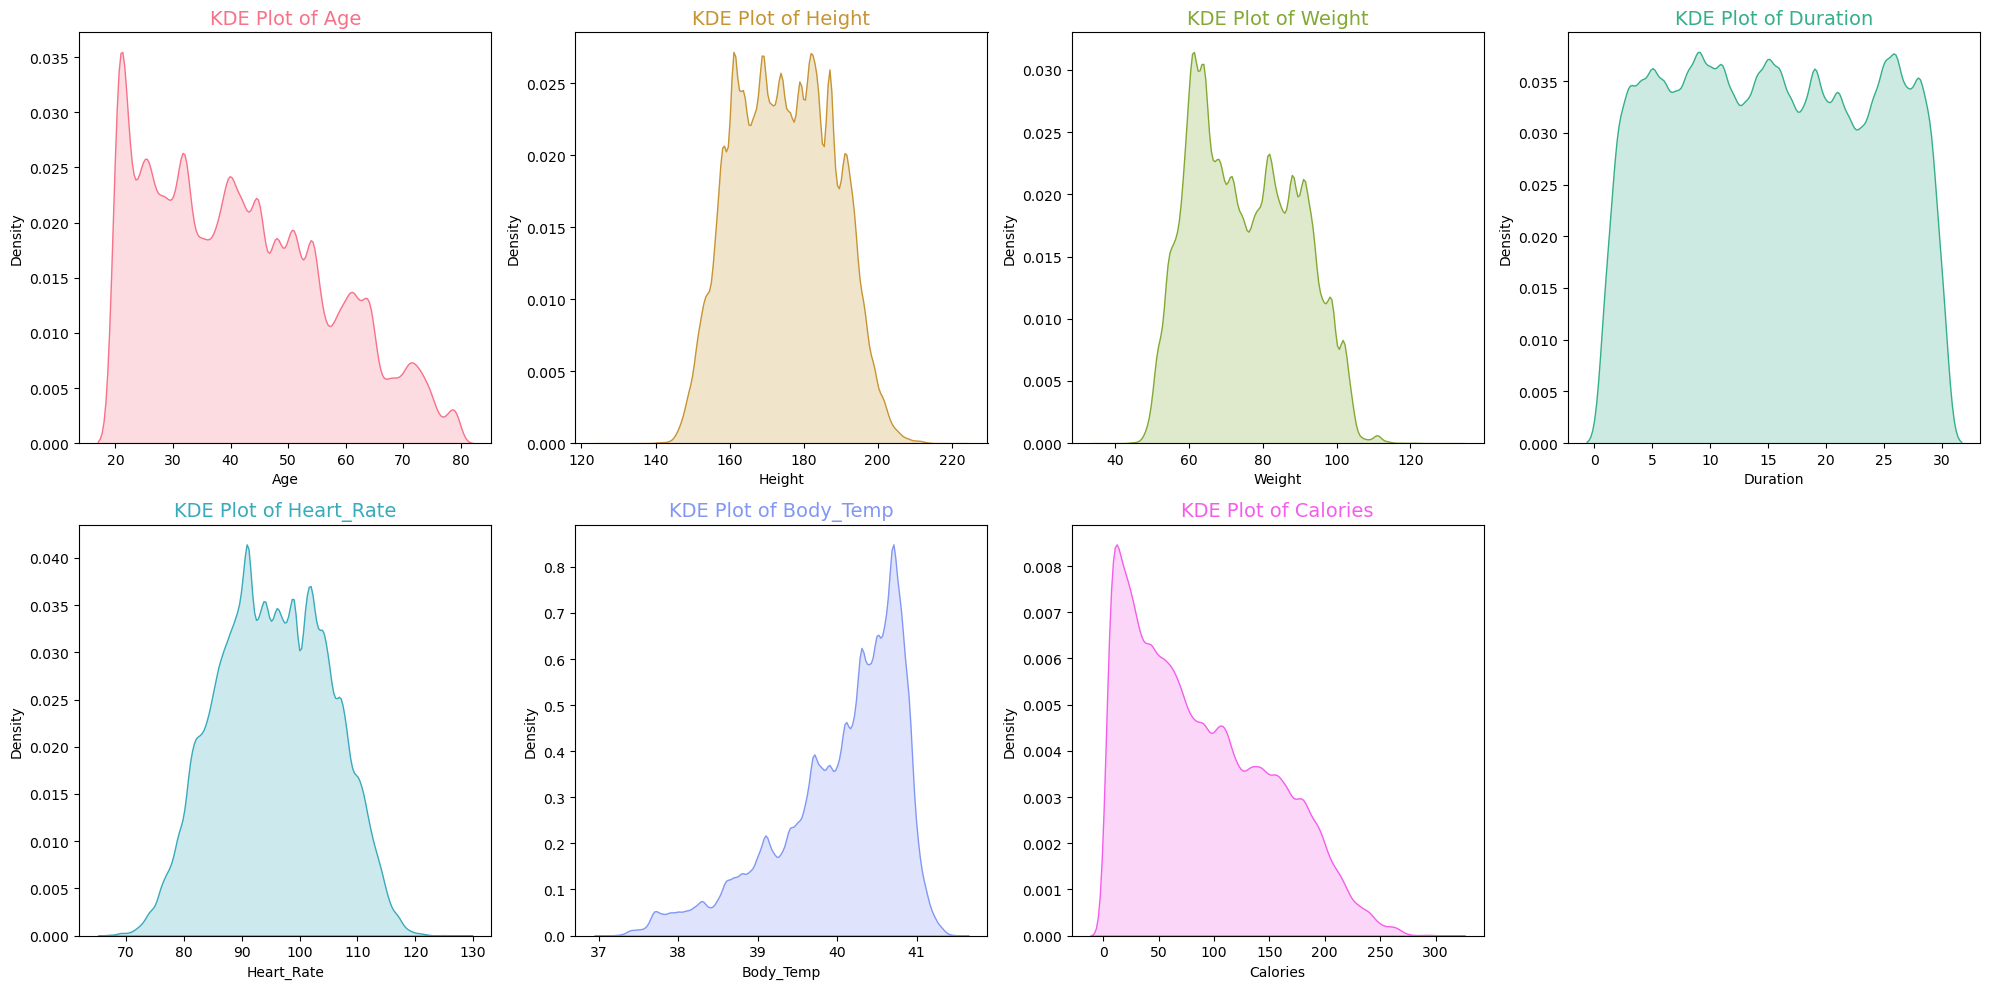

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt

# 建立一組色彩，用 seaborn 提供的 'husl' 調色盤，根據數值特徵的數量指定顏色數量
colors = sns.color_palette('husl', len(numerical_features))

# 計算列數：每行最多放 4 張圖，所以使用 ceiling 除法計算所需行數（rows）
# 「無條件進位除法」,天花板除法（ceiling division）
rows = -(-len(numerical_features) // 4)

# 設定整體圖表畫布大小（寬度固定 20，高度隨行數變動）
plt.figure(figsize=(20, 5 * rows)) # 圖表高度>>5為預設高度*rows數

# 使用 enumerate 搭配 zip 同時取得特徵名稱與對應的顏色
# i 為圖的位置編號（從 1 開始）
for i, (col, color) in enumerate(zip(numerical_features, colors), 1):

    # 每張子圖的配置位置（rows 行、4 列，第 i 個子圖）
    plt.subplot(rows, 4, i)

    # 畫出 KDE 曲線圖（核密度估計圖），加上填滿區域（fill=True），使用對應顏色
    sns.kdeplot(data=train_df, x=col, fill=True, color=color)

    # 設定子圖標題與顏色
    plt.title(f'KDE Plot of {col}', fontsize=14, color=color)

    # X/Y 軸標籤
    plt.xlabel(col)
    plt.ylabel('Density')

# 自動調整子圖之間的間距，避免重疊
plt.tight_layout()

# 顯示圖表
plt.show()

### 類別特徵視覺化（Categorical Features）

在原始資料集中，Sex 為唯一的類別型特徵，用以表示受測者的性別。透過下圖圓餅圖（Pie Chart）可視化各性別的分布情況。  
	•	資料共包含兩個類別：Male 與 Female  
	•	兩者的比例相當，約為 50% / 50%  
	•	因為性別屬於具辨識力的基本人口統計資訊，因此可直接保留作為模型的輸入特徵  

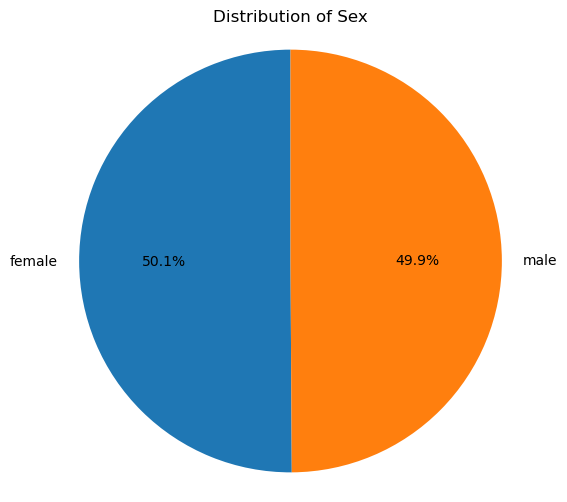

In [70]:
# 統計 Sex 欄位中每個類別的出現次數（例如 Male / Female）
#value_counts() 是 Pandas 的方法，用來統計欄位中每個值出現的次數
sex_counts = train_df["Sex"].value_counts()

plt.figure(figsize=(6, 6))  # 建立一張 6x6 英吋大小的圖表

#建立「圓餅圖（Pie Chart）」來可視化性別比例。
#autopct='%1.1f%%'：自動顯示每塊所佔百分比，小數點 1 位（如：78.4%）
plt.pie(sex_counts, labels=sex_counts.index, autopct='%1.1f%%', startangle=90)

plt.title("Distribution of Sex")
plt.axis("equal")
plt.show()


**類別特徵資訊小結（Summary of Categorical Features）**

| 特徵名稱 | 類型     | 類別數 | 分布情形   | 處理建議                    |
|----------|----------|--------|------------|-----------------------------|
| `Sex`    | 類別型   | 2 類別 | 約各 50%    | Label Encoding，並建立交叉特徵如 `Sex_AgeGroup` |

> 備註：`Sex` 欄位為二元類別，適合直接使用 Label Encoding，也可與其他欄位（如年齡、風險等）做組合產生交叉特徵，提升模型表現。